In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, EvalPrediction
from datasets import load_dataset, DatasetDict
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch

In [4]:
def hex_to_decimal(hex_num):
    try:
        # Convert the hexadecimal string to decimal
        decimal_num = int(hex_num, 16)
        return decimal_num
    except ValueError:
        return 0
    
def display_random_palette(df):
    # Select a random row
    random_row = df.sample().iloc[0]

    # Extract the description and colors
    description = random_row["description"]
    colors = [random_row["color1"], random_row["color2"], random_row["color3"], random_row["color4"], random_row["color5"]]

    # Output the description
    print(f"Description: {description}")

    # Display the colors as a horizontal bar
    fig, ax = plt.subplots(figsize=(8, 2))
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

    ax.set_xlim(0, 5)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

def convert_df(df):
    #converts the csv from columns of hex to 3 columns of RGB in dec
    new_df = pd.DataFrame()
    new_df["description"] = df["description"]
    for color_col in [col for col in df.columns if col != 'description']:
        R = []
        G = []
        B = []
        for color in df[color_col]:
            #given a col, split into R,G,B
            color = color[1:]
            R.append((hex_to_decimal(color[0:2]))/255)
            G.append((hex_to_decimal(color[2:4]))/255)
            B.append((hex_to_decimal(color[4:6]))/255)
        #add the new columns 
        new_df[color_col+"_R"] = R
        new_df[color_col+"_G"] = G
        new_df[color_col+"_B"] = B
    return new_df

def organize_colors(df):
    for index, row in df.iterrows():
        colors = []
        color_dict = {}
        for color in row[1:]:
            color_values = color[1:]
            R = hex_to_decimal(color_values[0:2])
            G = hex_to_decimal(color_values[2:4])
            B = hex_to_decimal(color_values[4:6])
            colors.append((R,G,B))
            color_dict[(R,G,B)] = color
        lighest = max(colors, key=lambda x: sum(x))
        colors.remove(lighest)
        darkest = min(colors, key=lambda x: sum(x))
        colors.remove(darkest)
        sorted_tuples = sorted(colors, key=lambda x: (x[0], x[1], x[2]), reverse=True)
        df.at[index, 'color1'] = color_dict[lighest]
        df.at[index, 'color2'] = color_dict[sorted_tuples[0]]
        df.at[index, 'color3'] = color_dict[sorted_tuples[1]]
        df.at[index, 'color4'] = color_dict[sorted_tuples[2]]
        df.at[index, 'color5'] = color_dict[darkest]
    return df

        

In [4]:
df = pd.read_csv("palette_hex.csv")
new_df = organize_colors(df)
new_df.to_csv("palette_ordered.csv", index = False)
df = pd.read_csv("palette_ordered.csv")
new_df = convert_df(df)
new_df.to_csv("palette_dec.csv", index = False)

In [5]:
dataset = load_dataset('csv', data_files='palette_dec.csv')
labels = [label for label in dataset['train'].features.keys() if label not in ['description']]
train_testvalid = dataset['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
    text = examples["description"]
    encoding = tokenizer(text, truncation=True, padding="max_length", max_length=10)
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}

    labels_matrix = np.zeros((len(text), len(labels)))
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    # Ensure labels remain as NumPy array
    encoding["labels"] = labels_matrix
    return encoding

/restricted/projectnb/cifulab/Sam/website/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=[] )

Map:   0%|          | 0/4164 [00:00<?, ? examples/s]

Map:   0%|          | 0/521 [00:00<?, ? examples/s]

Map:   0%|          | 0/521 [00:00<?, ? examples/s]

In [8]:
encoded_dataset.set_format("torch")

In [9]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [10]:
batch_size = 8
metric_name = "rmse"

args = TrainingArguments(
    f"color_model/",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=40,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
)

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred

    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    rmse = np.sqrt(mse)
    return {"mse": mse, "mae": mae, "rmse":rmse}

In [11]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_for_regression
)

In [19]:
trainer.train()
trainer.save_model("models/")

/restricted/projectnb/cifulab/Sam/website/.venv/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


In [20]:
trainer.evaluate()

{'eval_loss': 0.4488574266433716,
 'eval_mse': 8.855853080749512,
 'eval_mae': 2.176762104034424,
 'eval_rmse': 2.9758784770965576,
 'eval_runtime': 0.2556,
 'eval_samples_per_second': 2038.476,
 'eval_steps_per_second': 258.233,
 'epoch': 40.0}

In [12]:
#a collection of filters for the logits
def normalize_list(numbers):
            min_val = min(numbers)
            max_val = max(numbers)
            normalized_numbers = []
            for num in numbers:
                normalized_num = (num - min_val) / (max_val - min_val)
                normalized_numbers.append(normalized_num)
            return normalized_numbers
def clamp_list(numbers):
  return [max(0, min(num, 1)) for num in numbers]
def sigmoid_list(numbers):
  return [(1/(1+np.exp(-float(x)))) for x in numbers]


In [13]:
def output_to_color(output):
    colors = []
    logits = sigmoid_list(output.logits.squeeze())
    for i in range(0,len(logits),3):
        R = float(logits[i])
        G = float(logits[i+1])
        B = float(logits[i+2])
        print(R,G,B)
        hex_code = "#"+str(hex(int(R*255))[2:].zfill(2))+str(hex(int(G*255))[2:].zfill(2))+str(hex(int(B*255))[2:].zfill(2))
        colors.append(hex_code)
    return colors
def display_colors(colors):
    # Display the colors as a horizontal bar
    fig, ax = plt.subplots(figsize=(8, 2))
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

In [16]:
#for if you have to load a model
model_directory = "models"

model = AutoModelForSequenceClassification.from_pretrained(model_directory)
tokenizer =  AutoTokenizer.from_pretrained(model_directory)

0.9847144161343961 0.9464854621042599 0.9047058830410717
0.9962625616289568 0.7282467347145419 0.05625517750042631
0.9826090719277193 0.4292107564028588 0.255985797072936
0.9709429411977035 0.2177630861012605 0.012386391777274732
0.0497648906231494 0.010237690949466242 0.012017406842802532


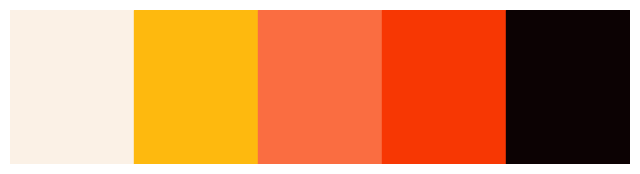

In [39]:
text = "pikachu"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}
prediction = trainer.model(**encoding)
display_colors(output_to_color(prediction))

# Upload the model to HuggingFace

In [1]:
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login

In [2]:
notebook_login()

In [ ]:
model_id = "Palette AI" #@param {type:"string"}

description = """
A Sam Wu Creation

Check out the GitHub at 
"""
task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'
metric_value = trainer.callback_metrics['val_acc'].item()

# Delete model folder, as we (re)create it here.
if Path('./model').exists():
    shutil.rmtree('./model')

token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

hf_username = HfApi().whoami()['name']
model_url = HfApi().create_repo(token=token, repo_id=model_id, exist_ok=True)
model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
model.save_pretrained(model_repo.local_dir)
feature_extractor.save_pretrained(model_repo.local_dir)

# Copy over tensorboard logs from lightning_logs/ into ./model/runs/
tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
model_repo_logs_path.mkdir(exist_ok=True, parents=True)
shutil.copy(tensorboard_logs_path, model_repo_logs_path)

# Copy over a few example images
example_images_dir = Path(model_repo.local_dir) / 'images'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](images/{example_image_path})
'''
example_images_markdown = ""
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    image_path = sorted(folder.glob('*'))[0]
    example_image_path = example_images_dir / f"{class_name.replace(' ', '_')}{image_path.suffix}"
    shutil.copy(image_path, example_image_path)
    example_images_markdown += image_markdown_template.format(
        class_name=class_name,
        example_image_path=example_image_path.name
    )


# Prepare README.md from information gathered above
readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")